<a href="https://colab.research.google.com/github/siddhant-uniyal/ML_Fundamentals/blob/main/Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing and Installing all the necessary libaries

In [ ]:
!pip install exkmc yellowbrick -q
!pip install ipympl #k-means 3d visualisation mein cluster's weren't visible. so tried to make a 3d movable plot
!pip install clusteval #for dendrograms
!pip install kneed #for finding the elbow point in k distance graph for eps in dbscan
!pip install gdown #download dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdown
from mpl_toolkits.mplot3d import Axes3D #for 3d plots

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift, SpectralClustering #clustering methods
from sklearn.metrics import silhouette_score #score from [-1,1] for how good a cluster is. -1 -> no clearly defined separation , 1: distinguishable and separate
from sklearn.preprocessing import StandardScaler #for scaling of dataset
from sklearn.decomposition import PCA #dimensional reduction

from yellowbrick.cluster import KElbowVisualizer #library specifically for finding optimal no of clusters
from ExKMC.Tree import Tree #explainable k means. explains why a cluster was formed by displaying the thresholds used to form clustering logic
from IPython.display import Image,display #used for displaying
from ipywidgets import interact #for interaction
import os

import warnings
warnings.filterwarnings("ignore")

In [ ]:
samsung_train_file_id = '1QyddY6ip91MVeFUB5xuQmitqePNSRQZW'
samsung_train_labels_file_id = '1nK_643OQbbGLxqfSWddDA9r8W8j0rD05'
samsung_test_file_id = '1wY9GSIBt9jTLVMKyBa2fvoG7MpjaYTBl'
samsung_test_labels_file_id = '1S8UxwU6qQ7EqRwQIB_ZrBt8-aFf6sgKl'
samsung_train_target_path = 'samsung_train.txt'
samsung_train_labels_target_path = 'samsung_train_labels.txt'
samsung_test_target_path = 'samsung_test.txt'
samsung_test_labels_target_path = 'samsung_test_labels.txt'

gdown.download(f'https://drive.google.com/uc?id={samsung_train_file_id}', samsung_train_target_path, quiet=False)
gdown.download(f'https://drive.google.com/uc?id={samsung_train_labels_file_id}', samsung_train_labels_target_path , quiet=False)
gdown.download(f'https://drive.google.com/uc?id={samsung_test_file_id}', samsung_test_target_path , quiet=False)
gdown.download(f'https://drive.google.com/uc?id={samsung_test_labels_file_id}', samsung_test_labels_target_path, quiet=False)

In [8]:
X_train = np.loadtxt(samsung_train_target_path)
y_train = np.loadtxt(samsung_train_labels_target_path).astype(str) #cause they're all numbers

X_test = np.loadtxt(samsung_test_target_path)
y_test = np.loadtxt(samsung_test_labels_target_path).astype(str)


#understanding how data is laid out
# xt_df = pd.DataFrame(X_train)
# yt_df = pd.DataFrame(y_train)

# xt_df
# yt_df


In [9]:
#assert for checking if condition(s) is/are True
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

# **Pre-processing**

In [10]:
#no need for labels so combined both train and test in one each for X and y

X = np.vstack((X_train , X_test)) #since X is multi column single row essentially , vertical stacking
y = np.hstack((y_train , y_test)) #Y is basically multi row , single column , horizontal stacking

#seeing structure
# x_df = pd.DataFrame(X)
# x_df
# y_df = pd.DataFrame(y)
# y_df

In [11]:
print(np.unique(y))

['1.0' '2.0' '3.0' '4.0' '5.0' '6.0']


In [12]:
n_classes = len(np.unique(y))

In [13]:
activities = [
    "walking",
    "going up the stairs",
    "going down the stairs",
    "sitting",
    "standing",
    "lying down"
]

In [14]:
from sklearn.preprocessing import StandardScaler #for scaling of dataset
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

#checking if it's right
# means = X_scaled.mean(axis=0)
# stds = X_scaled.std(axis=0)

# print(means)
# print(stds)


# **Dimensionality Reduction using PCA**

In [15]:
from sklearn.decomposition import PCA

In [16]:
pc = PCA(n_components=0.9,random_state=17)
pc.fit(X_scaled)
X_pca = pc.transform(X_scaled)

# df = pd.DataFrame(X_pca)
# df
# checking if it's right
# means = X_pca.mean(axis=0)
# stds = X_pca.std(axis=0)
# print(means)
# print(stds)

# means are ok but deviations are not. start extremely high at 16,5,3,2 then level off till one gradually.
# that's because , PCA only keeps the dimensions that have a lot of variance since a dimensions variance is what really explains patterns , trends in the data
# PCs are assigned in descending order of variance
# hence why the first PC has a lot of SD and then it decreases gradually
# also why we should plot all graphs with only 1st,2nd,3rd columns of X_pca

In [17]:
X_pca.shape

# better sense of X_pca
# df = pd.DataFrame(X_pca)
# df

(10299, 65)

Shape of X was (10299, 561) i.e 561 dimensions

Shape of X_pca is (10299, 65) i.e. 65 dimenisons

Hence we have successfully reduced dimensions using PCA.

# K-Means Clustering (Partition-Based Clustering)

### 2 Dimensional Visualization

In [18]:
def kmeans_clustering(num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42) #model
    kmeans_labels = kmeans.fit_predict(X_pca) #1d array of predicted labels
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', edgecolors='k') #c='' matlab same colours will be assigned to different labels
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='X', label='Centroids')
    plt.xlabel('Feature 1 (Standardized)')
    plt.ylabel('Feature 2 (Standardized)')
    plt.title('K-Means Clustering')
    plt.legend()
    plt.show()

low = 2
high = 6
scale = 1

interact(kmeans_clustering, num_clusters=(low,high,scale))


#trying to figure out what .cluster_centers_ and kmeans_labels actually is
#kmeans = KMeans(n_clusters = 6 , random_state = 42)
#labels = kmeans.fit_predict(X_pca)
#centres = kmeans.cluster_centers_
#1,2.. were automatically assigned to each data point at the time of creation of clusters. 1 goes to each data point which belongs to the cluster first created(which is completely coincidental) , 2 goes to each in the second cluster created and so on
#centres_df = pd.DataFrame(centres)
#centres_df
#labels_df = pd.DataFrame(labels)
#labels_df

interactive(children=(IntSlider(value=4, description='num_clusters', max=6, min=2), Output()), _dom_classes=('…

<function __main__.kmeans_clustering(num_clusters)>

### 3 Dimensional Visualization

In [19]:


def kmeans_3d_clustering(num_clusters):
    kmeans_3d = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_3d_labels = kmeans_3d.fit_predict(X_pca)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=kmeans_3d_labels, cmap='viridis', edgecolors='k')
    ax.scatter(kmeans_3d.cluster_centers_[:, 0], kmeans_3d.cluster_centers_[:, 1], kmeans_3d.cluster_centers_[:,2], s=500, c='red', marker='o', label='Centroids')
    ax.set_xlabel('Feature 1 (Standardized)')
    ax.set_ylabel('Feature 2 (Standardized)')
    ax.set_zlabel('Feature 3 (Standardized)')
    ax.set_title('K-Means Clustering (3D)')
    plt.show()

interact(kmeans_3d_clustering, num_clusters=(2, 6, 1))


#cluster centres weren't visible so tried a 3d plot that can be dragged , lagging a lot idk why
# %matplotlib widget

# kmeans_3d = KMeans(n_clusters=6, random_state=42)
# kmeans_3d_labels = kmeans_3d.fit_predict(X_pca)

# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=kmeans_3d_labels, cmap='viridis', edgecolors='k')
# ax.scatter(kmeans_3d.cluster_centers_[:, 0], kmeans_3d.cluster_centers_[:, 1], kmeans_3d.cluster_centers_[:,2], s=500, c='red', marker='o', label='Centroids')
# ax.set_xlabel('Feature 1 (Standardized)')
# ax.set_ylabel('Feature 2 (Standardized)')
# ax.set_zlabel('Feature 3 (Standardized)')
# ax.set_title('Kmeans Clustering (3D)')
# plt.show()

interactive(children=(IntSlider(value=4, description='num_clusters', max=6, min=2), Output()), _dom_classes=('…

<function __main__.kmeans_3d_clustering(num_clusters)>

### Elbow Point

Elbow Method to determine the number of clusters to be formed:


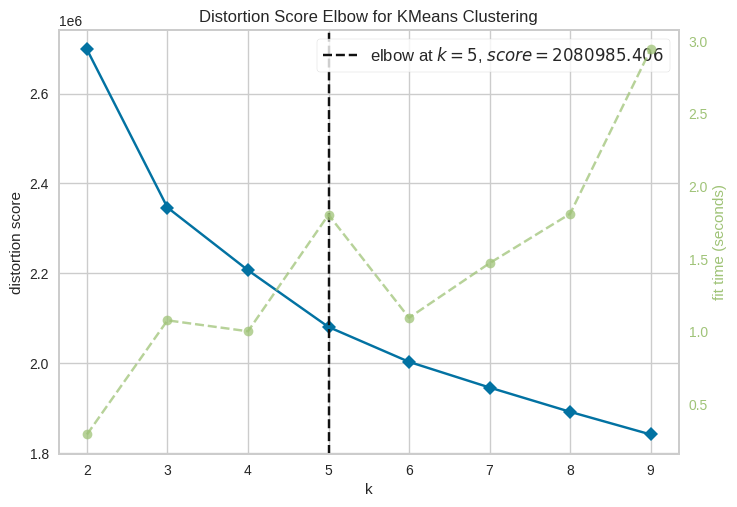

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
print('Elbow Method to determine the number of clusters to be formed:')

Elbow_M = KElbowVisualizer(KMeans(), k=(2, 10))
Elbow_M.fit(X_pca)
Elbow_M.show()

In [21]:
from sklearn.metrics.cluster import adjusted_rand_score
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)
adjusted_rand_score(y, kmeans_labels)


0.420052557165744

In [22]:
def explainable_KMC(num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_pca)
    tree = Tree(k=num_clusters)
    tree.fit(X_pca, kmeans)
    tree.plot(filename="test", feature_names=activities)
    display(Image(filename='test.gv.png'))
    os.remove("test.gv.png")
    os.remove("test.gv")

interact(explainable_KMC,num_clusters=(2,6,1))

#each root has a threshold from which either more thresholds or clusters are formed. basically a decision tree


interactive(children=(IntSlider(value=4, description='num_clusters', max=6, min=2), Output()), _dom_classes=('…

<function __main__.explainable_KMC(num_clusters)>

# Agglomerative Clustering


### 2 Dimensional Visualization

In [23]:
def agglomerative_clustering(num_clusters):
  agglomerative = AgglomerativeClustering(n_clusters=num_clusters)
  agglomerative_labels = agglomerative.fit_predict(X_pca)
  plt.figure(figsize=(8, 6))
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agglomerative_labels, cmap='viridis', edgecolors='k')
  plt.xlabel('Feature 1 (Standardized)')
  plt.ylabel('Feature 2 (Standardized)')
  plt.title('Agglomerative Clustering')
  plt.show()

interact(agglomerative_clustering, num_clusters=(2,6,1))

interactive(children=(IntSlider(value=4, description='num_clusters', max=6, min=2), Output()), _dom_classes=('…

<function __main__.agglomerative_clustering(num_clusters)>

### 3 Dimensional Visualization

In [24]:
def agglomerative_3d_clustering(num_clusters):
    agglomerative_3d = AgglomerativeClustering(n_clusters=num_clusters)
    agglomerative_3d_labels = agglomerative_3d.fit_predict(X_pca)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=agglomerative_3d_labels, cmap='viridis', edgecolors='k')
    ax.set_xlabel('Feature 1 (Standardized)')
    ax.set_ylabel('Feature 2 (Standardized)')
    ax.set_zlabel('Feature 3 (Standardized)')
    ax.set_title('Agglomerative Clustering (3D)')
    plt.show()

interact(agglomerative_3d_clustering, num_clusters=(2,6,1))

# %matplotlib widget

# agglomerative_3d = AgglomerativeClustering(n_clusters=6, random_state=42)
# agglomerative_3d_labels = agglomerative_3d.fit_predict(X_pca)

# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=agglomerative_3d_labels, cmap='viridis', edgecolors='k')
# ax.set_xlabel('Feature 1 (Standardized)')
# ax.set_ylabel('Feature 2 (Standardized)')
# ax.set_zlabel('Feature 3 (Standardized)')
# ax.set_title('Agglomerative Clustering (3D)')
# plt.show()

interactive(children=(IntSlider(value=4, description='num_clusters', max=6, min=2), Output()), _dom_classes=('…

<function __main__.agglomerative_3d_clustering(num_clusters)>

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [00:00<00:00, 207.70it/s]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.
[clusteval] >INFO> Retrieving input data set.
[clusteval] >INFO> Plotting the dendrogram with optimized settings: metric=euclidean, linkage=ward, max_d=57.686. Be patient now..
[clusteval] >INFO> Compute cluster labels.


{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [10.0, 10.0, 30.0, 30.0],
  [45.0, 45.0, 55.0, 55.0],
  [75.0, 75.0, 85.0, 85.0],
  [65.0, 65.0, 80.0, 80.0],
  [50.0, 50.0, 72.5, 72.5],
  [115.0, 115.0, 125.0, 125.0],
  [135.0, 135.0, 145.0, 145.0],
  [120.0, 120.0, 140.0, 140.0],
  [105.0, 105.0, 130.0, 130.0],
  [95.0, 95.0, 117.5, 117.5],
  [61.25, 61.25, 106.25, 106.25],
  [175.0, 175.0, 185.0, 185.0],
  [165.0, 165.0, 180.0, 180.0],
  [195.0, 195.0, 205.0, 205.0],
  [215.0, 215.0, 225.0, 225.0],
  [200.0, 200.0, 220.0, 220.0],
  [172.5, 172.5, 210.0, 210.0],
  [155.0, 155.0, 191.25, 191.25],
  [235.0, 235.0, 245.0, 245.0],
  [255.0, 255.0, 265.0, 265.0],
  [275.0, 275.0, 285.0, 285.0],
  [260.0, 260.0, 280.0, 280.0],
  [240.0, 240.0, 270.0, 270.0],
  [173.125, 173.125, 255.0, 255.0],
  [315.0, 315.0, 325.0, 325.0],
  [305.0, 305.0, 320.0, 320.0],
  [295.0, 295.0, 312.5, 312.5],
  [335.0, 335.0, 345.0, 345.0],
  [355.0, 355.0, 365.0, 365.0],
  [375.0, 375.0, 385.0

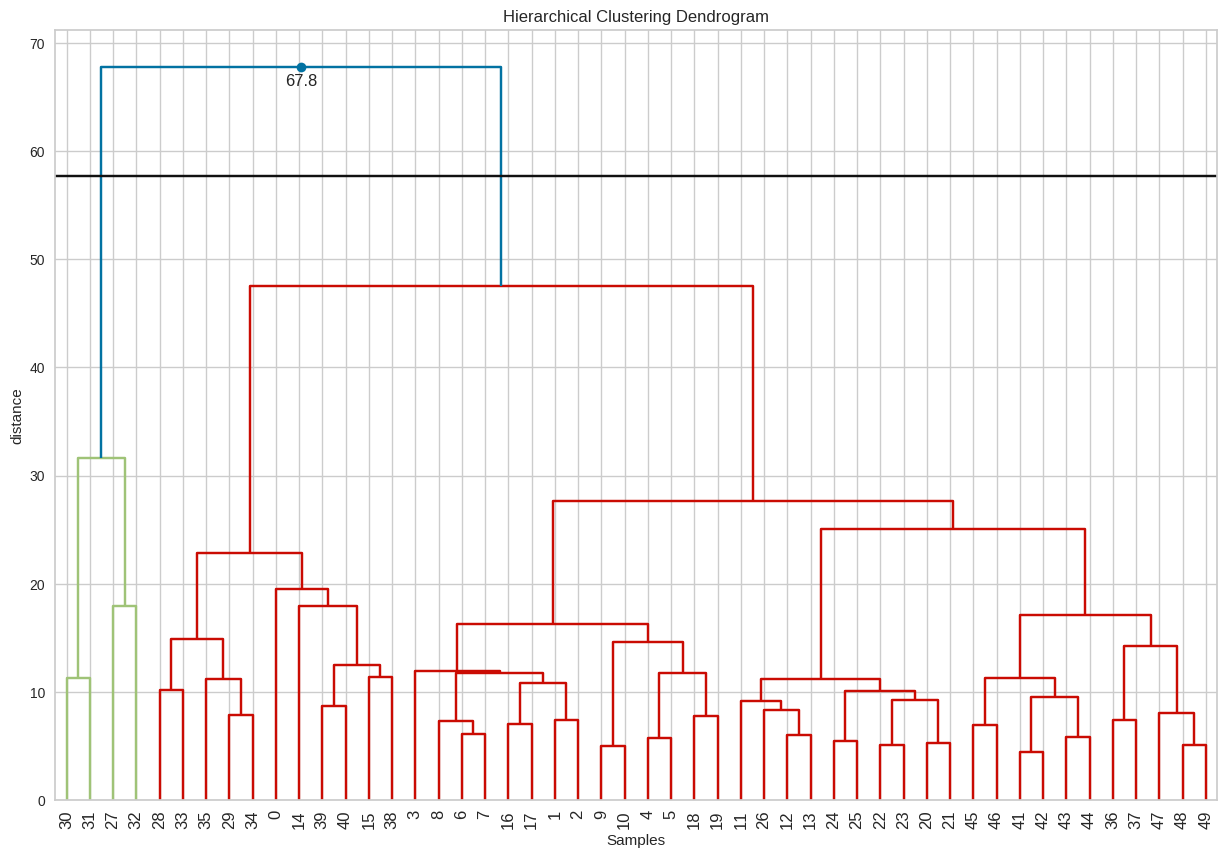

In [26]:
from clusteval import clusteval
ce = clusteval(cluster='agglomerative', evaluate='silhouette')
results = ce.fit(X_pca[:50]) #dk why it's not working properly for the entire data
ce.dendrogram()

# DBSCAN Clustering

### 2 Dimensional Visualization

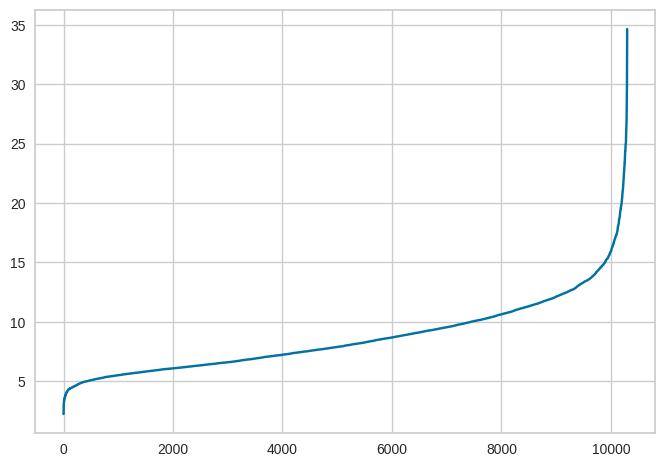

In [27]:

#doing this for finding eps value
#first plotting k-distance graph
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

neighbors = NearestNeighbors(n_neighbors=130)

neighbors_fit = neighbors.fit(X_pca)

distances, indices = neighbors_fit.kneighbors(X_pca)

distances = np.sort(distances, axis=0)

distances = distances[:,1]

plt.plot(distances)


In [28]:
#finding accurate elbow point using KneeLocator
y = distances
x = list(range(len(y)))

kneedle = KneeLocator(x, y, S=3.0, curve="convex", direction="increasing")

print(round(kneedle.knee_y, 3))

14.713


In [29]:

def dbscan_clustering(eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(X_pca)
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', edgecolors='k')
    plt.xlabel('Feature 1 (Standardized)')
    plt.ylabel('Feature 2 (Standardized)')
    plt.title('DBSCAN')
    plt.show()


interact(dbscan_clustering, eps=(13 , 16 , 0.2), min_samples=(66 , 130 , 1)) #[minSamples + 1 , 2*minSamples]

interactive(children=(FloatSlider(value=14.0, description='eps', max=16.0, min=13.0, step=0.2), IntSlider(valu…

<function __main__.dbscan_clustering(eps, min_samples)>

### 3 Dimensional Visualization

In [30]:

def dbscan_3d_clustering(eps, min_samples):
    dbscan_3d = DBSCAN(eps=eps , min_samples = min_samples)
    dbscan_labels = dbscan_3d.fit_predict(X_pca)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=dbscan_labels, cmap='viridis', edgecolors='k')
    ax.set_xlabel('Feature 1 (Standardized)')
    ax.set_ylabel('Feature 2 (Standardized)')
    ax.set_zlabel('Feature 3 (Standardized)')
    ax.set_title('DBSCAN (3D)')
    plt.show()


interact(dbscan_3d_clustering, eps=(13 , 16 , 0.2), min_samples=(66,130,1))

interactive(children=(FloatSlider(value=14.0, description='eps', max=16.0, min=13.0, step=0.2), IntSlider(valu…

<function __main__.dbscan_3d_clustering(eps, min_samples)>

# Mean Shift Clustering

### 2 Dimensional Visualization

In [31]:
#wanna know actual correct bandwidth instead of randomizing

from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X_pca, quantile=0.3)

print(bandwidth)

21.163703919286135


In [32]:
def meanshift_clustering(n_band):
    mean_shift = MeanShift(bandwidth=n_band)
    mean_shift_labels  = mean_shift.fit_predict(X_pca)
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=mean_shift_labels, cmap='viridis', edgecolors='k')
    plt.xlabel('Feature 1 (Standardized)')
    plt.ylabel('Feature 2 (Standardized)')
    plt.title('Mean Shift Clustering')
    plt.show()


interact(meanshift_clustering, n_band=(20,23,.2))

interactive(children=(FloatSlider(value=21.0, description='n_band', max=23.0, min=20.0, step=0.2), Output()), …

<function __main__.meanshift_clustering(n_band)>

### 3 Dimensional Visualization

In [33]:

def meanshift_clustering(n_band):

  mean_shift_3d = MeanShift(bandwidth = n_band)
  mean_shift_3d_labels = mean_shift_3d.fit_predict(X_pca)

  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=mean_shift_3d_labels, cmap='viridis', edgecolors='k')
  ax.set_xlabel('Feature 1 (Standardized)')
  ax.set_ylabel('Feature 2 (Standardized)')
  ax.set_zlabel('Feature 3 (Standardized)')
  ax.set_title('Mean Shift Clustering (3D)')
  plt.show()


interact(meanshift_clustering, n_band=(20,23,0.1))

interactive(children=(FloatSlider(value=21.0, description='n_band', max=23.0, min=20.0), Output()), _dom_class…

<function __main__.meanshift_clustering(n_band)>

Spectral Clustering :
It basically clusters the data by making a graph representation of it.

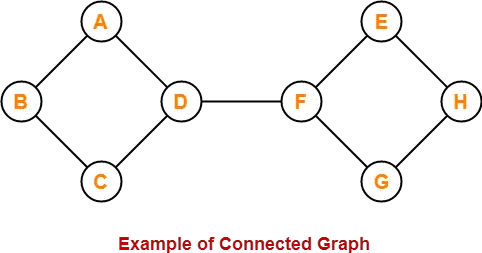

So in this case , the goal is to partition the graph into appropriate clusters. So here , cluster_nos = 2 , with one having ABCD and other having EFGH

The graph representation of a dataset will have the vertices = the data points , and the edges = the pairwise similarity between 2 data points , defined by something like:

1) K-nearest neighbors : each vertex is connected to it's k nearest neighbors

2) Epsilon neighborhood : each vertex is connected to all vertices in a sphere of radius epsilon.

So step 1: Similarity Graph.

Now step 2: Laplacian Matrix

First make an Affinity Matrix , with rows and columns both = the data points.
The entries of the matrix will be the similarities of pairwise vertices. Similarity can be thought of as the strength of their connection.

Then make a Weight matrix directly derived from Affinity Matrix. Basically converts the similarities into weights.

Then make a Degree Matrix , which contains the sum of edge weights for each vertex in the graph. This is a diagonal matrix. It accounts for the degree(of connectivity) of each vertex.

Finally , a Laplacian Matrix is formed. It's represented as L = D - W.

Note that , since A had all diag elements = 0 , diag elements of L are all nonnegative. And since non-diag elements of D are all 0 , the non diagonal elements of L are all negative.

This is important because :    
1) In the process mentioned below , Laplacian matrix can't be singular. Hence , diag sum should be > 0

2) The negativity of each element of Laplacian represents the weighted connectivity of vertices. Greater the element , lesser the connection's weight. (Since it's negative).

Important :

1) Eigenvectors : Think of a linear transformation done on a vector. Thus , it's x and y components are now different.The vector(s) that don't change their alignment(direction remains same) and only change in magnitude(squished or lengthened) is/are called the eigenvector(s) of the linear transformation. Note that linear transformations are matrices.


2) Eigenvalues : The value by which the eigenvector gets squished/extended is called the eigenvalue of the eigenvector.


Step 3 : Extraction of info using Eigenvectors and Eigenvalues

Eigenvalue decomposition is carried out on the Laplacian Matrix. In simple words , certain mathematical equations are applied to find the eigenvalues of the Laplacian and then find eigenvectors corresponding to these eigenvalues. The process of finding these values requires the determinant of Laplacian to not be zero , hence why nonnegativity of it's trace is important.

Here's why it's done :    

1) Clustering can be done effectively , because one the of the things that happens with decomposition is that the dimensional space gets reduced , if the number of eigenvectors is less than the dimension of the Laplacian (which is equal to the number of datapoints).

2) There is a property , which states that the "spectral gap" of a Laplacian (basically the smallest non-zero eigenvalue) is a measure of how well-connected the graph is. The smaller it is , the lesser cuts required to make the necessary partitions. When we pass the num_clusters parameter , these are actually the number of cuts we want to make in the graph. The first "num_clusters" smallest eigenvalues are selected , for the best possible clustering.

3)Similar to PCA , eigenvectors basically represent the directions along which the data varies the most in the new space.The eigenvectors with highest eigenvalues represent highest variation. We want least variance , since we want to cluster the data. Hence , eigenvectors with the least eigenvalues are chosen.

Step 4 : Clustering

The eigenvectors chosen now represent all the data points in the new feature space. All that's left to do is to use a simple clustering algorithm , like K-Means , to cluster the points.



